###### TODO:

1.  Take MBDNL as the reference to quantify the error ( user relative error )

2.  Check for Cu and Alkaline Earth metals

3.  Find formal charges by beggar's analysis in MBDNL optimised geometry

4.  Consider absolute electronegetiy of each elements present also as a fetaure function ( for the mettalic things )

5.  Polarisibility 



In [48]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

### Checking Elements

In [49]:

comp = "CsCl"
d3 = pd.read_csv(f'd3/{comp}.csv')
mbd = pd.read_csv(f'mbd/{comp}.csv')


In [50]:
mbd.head()

,cell_length,energy,E-dispersion
0,4.143698,-6.987672,-0.46567
1,NaN,NaN,NaN
2,NaN,NaN,NaN
3,NaN,NaN,NaN
4,NaN,NaN,NaN


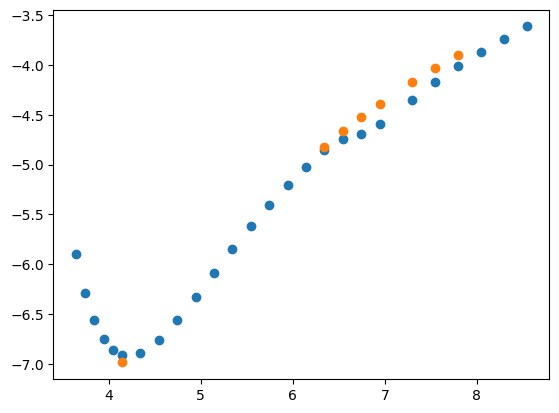

In [51]:
# plt.plot(cuppor['cell_length'], cuppor['energy'], 'o')
plt.scatter(d3['cell_length'], d3['energy'])

# plt.plot(copper_mbd['cell_length'], copper_mbd['energy'], 'o')
plt.scatter(mbd['cell_length'], mbd['energy'])

plt.show()

### Loading the feature functions from CSV

In [52]:

""" List of molecules strcutrue 
data = {
    "Mol": molecules,  # Molecule
    "Cat_EN": [0.98, 0.93, 0.82, 0.79, 1.90, 1.90, 0.98, 1.90, 1.31, 0.98, 0.93],  # Cation electronegativity
    "Ani_EN": [2.20, 2.20, 2.20, 2.20, 2.20, 1.90, 3.98, 2.66, np.nan, np.nan, np.nan],  # Anion electronegativity
    "Pol_C": [164.1, 162.7, 289.7, 400.9, 46.5, 46.5, 164.1, 46.5, 71.2, 164.1, 162.7],  # Cation polarizability
    "Pol_A": [4.51, 4.51, 4.51, 4.51, 4.51, 46.5, 0.56, 6.35, np.nan, np.nan, np.nan],  # Anion polarizability
    "Rad_C": [152.0, 186.0, 227.0, 343.0, 260.0, 128.0, 152.0, 128.0, 160.0, 152.0, 186.0],  # Cation radius (pm)
    "Rad_A": [53.0, 53.0, 53.0, 53.0, 53.0, np.nan, 147.0, 206.0, np.nan, np.nan, np.nan],  # Anion radius (pm)
    "CN": [6.0, 6.0, 6.0, 6.0, 6.0, np.nan, 6.0, 6.0, 6.0, np.nan, np.nan],  # Coordination number
    "Ion_C": [520.2, 495.8, 418.8, 376.6, 745.5, 745.5, 520.2, 745.5, 737.7, 520.2, 495.8],  # Cation ionization energy (kJ/mol)
    "Ion_A": [1312.0, 1312.0, 1312.0, 1312.0, 1312.0, np.nan, 1681.0, 1007.0, np.nan, np.nan, np.nan],  # Anion ionization energy (kJ/mol)
    "EA_A": [72.8, 72.8, 72.8, 72.8, 72.8, np.nan, 328.0, 295.0, np.nan, np.nan, np.nan],  # Anion electron affinity (kJ/mol)
    "EA_C": [59.6, 52.8, 48.4, 45.5, 119.2, 119.2, 59.6, 119.2, 0.0, 59.6, 52.8],  # Cation electron affinity (kJ/mol)
}

"""

# Create a DataFrame
df = pd.read_csv("ff_ionic.csv")

# Save to a CSV file
molecules = df['Mol'].values


molecules = molecules[:-5]
molecules


array(['LiH', 'NaH', 'KH', 'RbH', 'CsH', 'CsCl', 'LiCl'], dtype=object)

### Trimming the feature data frame

In [61]:
df = df.iloc[:8,0:8]

df['Sum_rad'] = df['RadV_C'] + df['RadV_A']
df['Diff_rad'] = df['RadV_C'] - df['RadV_A']
# df['Sum_pol'] = df['Pol_C'] + df['Pol_A']
# df['sum_ion'] = df['Ion_C'] + df['Ion_A']
# df['diff_ion'] = df['Ion_C'] - df['Ion_A']
df

,Mol,Pol_C,Pol_A,RadV_C,RadV_A,CN_C,Ion_C,Ion_A,Sum_rad,Diff_rad
0,LiH,164.1,4.51,60,150.00,6,5.392,13.590,210.00,-90.00
1,NaH,162.7,4.51,95,150.00,6,5.139,13.590,245.00,-55.00
2,KH,289.7,4.51,133,150.00,6,4.341,13.590,283.00,-17.00
3,RbH,400.9,4.51,148,150.00,6,4.177,13.590,298.00,-2.00
4,CsH,46.5,4.51,190,150.00,6,3.849,13.590,340.00,40.00
5,CsCl,46.5,0.56,190,1.81,6,3.849,17.423,191.81,188.19
6,LiCl,164.1,0.56,145,1.81,6,5.392,17.423,146.81,143.19
7,CuI,46.5,6.35,91,2.16,4,7.726,10.451,93.16,88.84


### Find all the combinations

In [58]:
## Generating all the cominations of the parameters

import itertools
import numpy as np
import pandas as pd

def generate_combinations_df(params_df, param_names):
    results = []

    # Convert all parameter values to numeric, coercing errors to NaN
    params_df = params_df.apply(pd.to_numeric, errors='coerce')

    # Precompute inverses of all parameters
    # Convert to float to handle integer to negative power issue
    params_inv_df = params_df.applymap(lambda x: np.power(float(x), -1) if pd.notnull(x) and x != 0 else np.nan)
    params_inv_df.columns = [f"{name}^(-1)" for name in param_names]

    # Combine original parameters and their inverses
    combined_params_df = pd.concat([params_df, params_inv_df], axis=1)
    combined_param_names = list(combined_params_df.columns)

    # Generate all subsets of parameters (combinations)
    for r in range(1, len(combined_param_names) + 1):
        for subset_indices in itertools.combinations(range(len(combined_param_names)), r):

            subset_names = [combined_param_names[i] for i in subset_indices]
            subset = combined_params_df[subset_names]

            # Replace NaN values with 0
            subset = subset.fillna(0)

            # Check if both a parameter and its inverse are in the subset
            invalid = False
            for name in subset_names:
                if name.endswith("^(-1)") and name[:-5] in subset_names:
                    invalid = True
                    break
                elif name in param_names and f"{name}^(-1)" in subset_names:
                    invalid = True
                    break

            if invalid:
                continue

            # Compute results for valid subsets
            expr_str = " * ".join(subset_names)
            expr_val = subset.prod(axis=1)
            results.append((expr_str, expr_val))

    return results

In [73]:

import os
import pandas as pd

takeSaved = True

all_expressions = []
expressions = []
# Define file name to save/load the results
cache_file = "cached_expressions.pkl"

if os.path.exists(cache_file) and takeSaved:
    # Load the cached results if they exist
    expressions = pd.read_pickle(cache_file)
    all_expressions = list(expressions.itertuples(index=False, name=None))
    print("Loaded cached expressions.")
else:
    # Perform the costly computation if cache does not exist
    print("Calculating expressions...")
    param_names = list(df.iloc[:,1:].columns)
    all_expressions = generate_combinations_df(df.iloc[:, 1:], param_names)
    expressions = pd.DataFrame(all_expressions, columns=['Expression', 'Value'])

    # Save the results to cache
    expressions.to_pickle(cache_file)
    print("Expressions cached.")

# Print the shape of the expressions DataFrame
print(expressions.shape)


Loaded cached expressions.
(19682, 2)


In [63]:
expressions.head()

,Expression,Value
0,Pol_C,0 164.1 1 162.7 2 289.7 3 400.9 4 ...
1,Pol_A,0 4.51 1 4.51 2 4.51 3 4.51 4 4...
2,RadV_C,0 60 1 95 2 133 3 148 4 190 5...
3,RadV_A,0 150.00 1 150.00 2 150.00 3 150.0...
4,CN_C,0 6 1 6 2 6 3 6 4 6 5 6 6 ...


### Adding the Result of Errors to the combinations 

Cheking Linear Corelations

In [40]:
%store -r res
res

[10.949597164494895,
 10.541726430016613,
 10.418474212336614,
 9.50800562688988,
 9.011645790668272,
 3.0259943135223364,
 4.711644133098936,
 2.281612873138524]

In [64]:

values_dict = {expr_str: expr_val for expr_str, expr_val in all_expressions}
values = pd.DataFrame(values_dict)
values['res'] = res


In [66]:
print(values.shape)

correlation = values.corr()

correlation.shape

(8, 19683)


(19683, 19683)

In [13]:
import dask.dataframe as dd

dask_values = dd.from_pandas(values, npartitions=10)
correlation = dask_values.corr().compute()

KeyboardInterrupt: 

In [67]:
results=correlation['res'].abs().sort_values(ascending=False)
print(results.iloc[0:20])
top_vars = results.iloc[1:20].index

res                                                                            1.000000
RadV_C * Diff_rad * CN_C^(-1) * Ion_A^(-1) * Sum_rad^(-1)                      0.998139
Diff_rad * CN_C^(-1) * Ion_C^(-1) * Ion_A^(-1) * Sum_rad^(-1)                  0.990518
RadV_C * Ion_C * Diff_rad * CN_C^(-1) * Ion_A^(-1)                             0.988844
RadV_A * CN_C * Ion_C * Ion_A * Pol_A^(-1)                                     0.987736
RadV_A * Ion_C * Ion_A * Pol_A^(-1)                                            0.987543
RadV_A * Ion_C * Ion_A * Pol_A^(-1) * CN_C^(-1)                                0.987238
Diff_rad * RadV_C^(-1) * RadV_A^(-1) * CN_C^(-1) * Ion_C^(-1) * Ion_A^(-1)     0.986675
Sum_rad * Diff_rad * RadV_C^(-1) * RadV_A^(-1) * CN_C^(-1) * Ion_A^(-1)        0.986666
RadV_C * Ion_C * Diff_rad * CN_C^(-1) * Sum_rad^(-1)                           0.986331
RadV_A * CN_C * Ion_C * Pol_A^(-1)                                             0.985976
RadV_A * Ion_C * Pol_A^(-1)     

### checking non linear Relation ( spearman )

In [65]:
non_linear_corr = values.corr(method='spearman')


In [68]:
temp=non_linear_corr['res'].abs().sort_values(ascending=False)
print(temp.iloc[0:30])
top_vars = temp.iloc[1:30].index

NameError: name 'non_linear_corr' is not defined

### kendal Corelations

In [67]:
kendall_corr = values.corr(method='kendall')

KeyboardInterrupt: 

In [69]:
temp = kendall_corr['res'].abs().sort_values(ascending=False)

print(temp.iloc[0:30])

NameError: name 'kendall_corr' is not defined

### More to try 
1. Mutual info regression 

2. Maximal Information Coefficient 

3.  Distance Correlation

### Final List of Results

In [70]:
results=correlation['res'].abs().sort_values(ascending=False)
print(results.iloc[0:20])
top_vars = results.iloc[1:20].index


res                                                                            1.000000
RadV_C * Diff_rad * CN_C^(-1) * Ion_A^(-1) * Sum_rad^(-1)                      0.998139
Diff_rad * CN_C^(-1) * Ion_C^(-1) * Ion_A^(-1) * Sum_rad^(-1)                  0.990518
RadV_C * Ion_C * Diff_rad * CN_C^(-1) * Ion_A^(-1)                             0.988844
RadV_A * CN_C * Ion_C * Ion_A * Pol_A^(-1)                                     0.987736
RadV_A * Ion_C * Ion_A * Pol_A^(-1)                                            0.987543
RadV_A * Ion_C * Ion_A * Pol_A^(-1) * CN_C^(-1)                                0.987238
Diff_rad * RadV_C^(-1) * RadV_A^(-1) * CN_C^(-1) * Ion_C^(-1) * Ion_A^(-1)     0.986675
Sum_rad * Diff_rad * RadV_C^(-1) * RadV_A^(-1) * CN_C^(-1) * Ion_A^(-1)        0.986666
RadV_C * Ion_C * Diff_rad * CN_C^(-1) * Sum_rad^(-1)                           0.986331
RadV_A * CN_C * Ion_C * Pol_A^(-1)                                             0.985976
RadV_A * Ion_C * Pol_A^(-1)     

### Cheking the final results

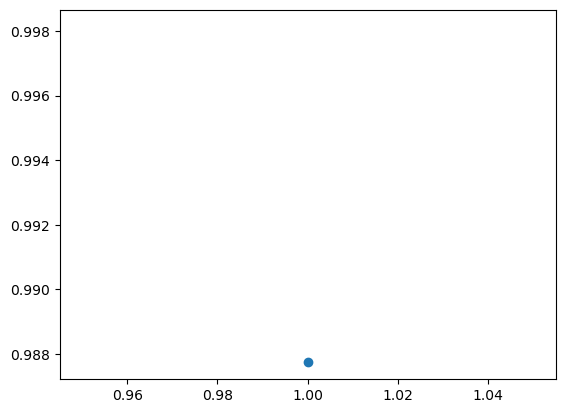

1.0


In [71]:

plt.scatter(results['res'],results[top_vars[3]])
plt.plot(results['res'],results[top_vars[0]])
plt.show()

values[top_vars[0]]


# param = df['Cat_EN']*df['Ani_EN']*df['Rad_C']*df['CN']*df['Ion_C']*df['Ion_A']

y = values[top_vars[0]]
x = values['res']


# y = list(values[top_vars[0]])[:4]+list(values[top_vars[0]])[5:]
# x = list(values['res'])[:4]+list(values['res'])[5:]

# plt.scatter(x,y)
# x

print(results['res'])


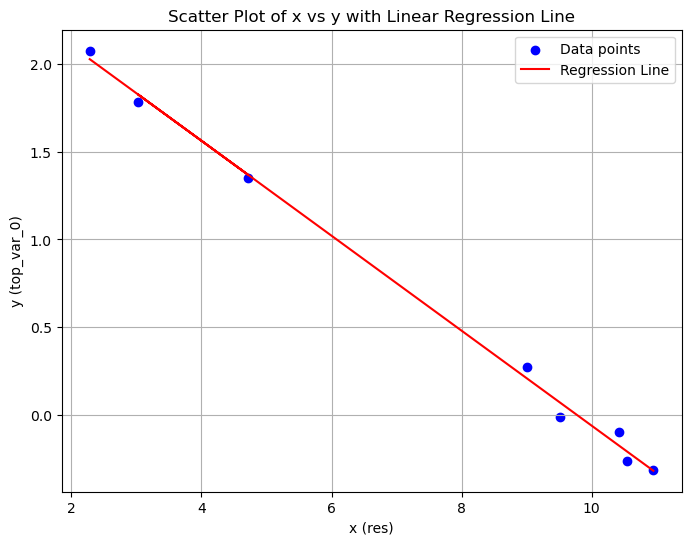

(0.996281101828317, 0.0031114621498014644, 'y = -0.2707x + 2.6455')

In [72]:
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

# Assuming x and y are Pandas Series
# Reshape x to a 2D array
x_reshaped = x.values.reshape(-1, 1)  # Convert x to a 2D array (n, 1)

# Create and fit the linear regression model
model = LinearRegression()
model.fit(x_reshaped, y)

# Get the slope (coefficient) and intercept
slope = model.coef_[0]  # model.coef_ gives the slope of the line
intercept = model.intercept_  # model.intercept_ gives the intercept

# Predict y values using the linear model
y_pred = model.predict(x_reshaped)

# Plot the data points and the regression line
plt.figure(figsize=(8, 6))
plt.scatter(x, y, color='blue', label='Data points')
plt.plot(x, y_pred, color='red', label='Regression Line')
plt.title('Scatter Plot of x vs y with Linear Regression Line')
plt.xlabel('x (res)')
plt.ylabel('y (top_var_0)')
plt.grid()
plt.legend()
plt.show()

# Calculate R^2 and MSE
r_squared = r2_score(y, y_pred)
msd = mean_squared_error(y, y_pred)

# Display the equation of the line
equation = f"y = {slope:.4f}x + {intercept:.4f}"
r_squared, msd, equation


In [112]:
import pickle

# Save the variable to a pickle file
with open('corel.pkl', 'wb') as f:
    pickle.dump(results, f)

In [23]:
# Plot each variable against `res`
plt.figure(figsize=(12, 8))

for i, var in enumerate(top_vars, 1):
    plt.subplot(4, 5, i)  # 4 rows, 5 columns for subplots
    
    # Plot the line
    plt.plot(values[var], values['res'], linestyle='-', color='blue', alpha=0.7)
    
    # Scatter plot with markers
    plt.scatter(values[var], values['res'], marker='o', color='red', alpha=0.8)
    
    # Annotate each point with its index
    for idx in range(len(values)):
        plt.text(values[var].iloc[idx], values['res'].iloc[idx], str(idx), fontsize=6, color='black', alpha=0.7)
    
    # Titles and labels
    plt.title(var)
    plt.xlabel(var)
    plt.ylabel('res')

plt.tight_layout()
plt.show()


NameError: name 'top_vars' is not defined

<Figure size 1200x800 with 0 Axes>

### Feature functions to be used

1. Electronegetivities of each atom involded

2. sum of electronegetivities 

3. Difference of electronegetivities

4. polarisibility

6. Redox potentials 

7. Atomic raiis , sum of atomic raii

8. Formal Charges ( dont know how to take that )

9. Also should have test data 

10. coordination number

### TODO:
1. Check the Y values more properly and accurately 

2. Add more compunds 

3. Try for more feature fucntions 


### relations 

1. RadV_C * Diff_rad * CN_C^(-1) * Ion_A^(-1) * Sum_rad^(-1)    